In [66]:
import pymc as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [2]:
data = pd.read_csv('clean_data.csv')
data

,participantID,item,wavfile,cond,step,yannyresp,condproper,yanny_prop,bias
0,s.00b4161e-2301-47b7-bbe0-5fb6872be4a5.txt,17,lopass_step5.mp3,lopass,1,0,low-pass filtered,0.0,Laurel
1,s.00b4161e-2301-47b7-bbe0-5fb6872be4a5.txt,52,hipass_step5.mp3,hipass,1,0,high-pass filtered,0.0,Laurel
2,s.00b4161e-2301-47b7-bbe0-5fb6872be4a5.txt,46,lopass_step6.mp3,lopass,2,0,low-pass filtered,0.0,Laurel
3,s.00b4161e-2301-47b7-bbe0-5fb6872be4a5.txt,53,hipass_step6.mp3,hipass,2,0,high-pass filtered,0.0,Laurel
4,s.00b4161e-2301-47b7-bbe0-5fb6872be4a5.txt,16,lopass_step4.mp3,lopass,7,1,low-pass filtered,0.0,Laurel
...,...,...,...,...,...,...,...,...,...
14168,s.ffcebd63-49ef-495a-8cab-3338b854d87e.txt,4,lopass_step6.mp3,lopass,2,0,low-pass filtered,1.0,Yanny
14169,s.ffcebd63-49ef-495a-8cab-3338b854d87e.txt,46,lopass_step6.mp3,lopass,2,0,low-pass filtered,1.0,Yanny
14170,s.ffcebd63-49ef-495a-8cab-3338b854d87e.txt,45,lopass_step5.mp3,lopass,1,0,low-pass filtered,1.0,Yanny
14171,s.ffcebd63-49ef-495a-8cab-3338b854d87e.txt,29,lopass_step3.mp3,lopass,6,1,low-pass filtered,1.0,Yanny


In [22]:
# re-encode participant IDs
unique_participant_ids = data['participantID'].unique()
id_map = {id_val: idx for idx, id_val in enumerate(unique_participant_ids)}
data['participantID_mapped'] = data['participantID'].map(id_map)

# re-encode condition
data['cond_encoded'] = data['cond'].astype('category').cat.codes

In [ ]:
mu_0 = pm.Normal('mu_0', mu = 0, sigma=10000)
    tau_0 = pm.Gamma('tau_0', alpha=0.1, beta=0.1)
    
    beta_0j = pm.Normal('beta_0j', mu=mu_0, sigma= (1 / tau_0), shape=n_districts)
    beta_1 = pm.Normal('beta_1', mu=0, sigma=10000)
    beta_2 = pm.Normal('beta_2', mu=0, sigma=10000)
    beta_3 = pm.Normal('beta_3', mu=0, sigma=10000)
    
    logit_pij = (beta_0j[df_train['district'].values] + 
                 beta_1 * df_train['urban'].values +
                 beta_2 * df_train['living.children'].values + 
                 beta_3 * df_train['age_mean'].values)
    
    y_ij = pm.Bernoulli('y_ij', 
                        logit_p = logit_pij,
                        observed = simulated_Y)

In [60]:
n_participants = data['participantID'].nunique()
n_participants

384

In [80]:
with pm.Model() as model:
    # Priors for fixed effects
    mu_0 = pm.Normal('mu_0', mu=0, sigma=100)

    beta_0j = pm.Normal("beta_0j", mu=mu_0, sigma=2, shape=n_participants)  # Intercept
    beta_step_j = pm.Normal("beta_step", mu=0, sigma=10, shape=n_participants)  # Effect of step
    beta_cond = pm.Normal("beta_cond", mu=0, sigma=10)  # Condition effects

    # # Logistic regression likelihood
    logit_pij = (
        beta_0j[data['participantID_mapped'].values]
        + beta_step_j[data['participantID_mapped'].values] * data["step"].values
        + beta_cond * data["cond_encoded"].values
    )

    # # Likelihood
    y_ij = pm.Bernoulli("y_ij", logit_p=logit_pij, observed=data["yannyresp"])

In [81]:
with model:
    trace = pm.sample(draws=2000, tune=1000, target_accept=0.9) 
    print(f'DONE')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_0, beta_0j, beta_step, beta_cond]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 784 seconds.


DONE


In [82]:
# Summarize results
import arviz as az
summary = az.summary(trace)
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_0,-8.848,0.217,-9.289,-8.468,0.003,0.002,3974.0,5571.0,1.0
beta_0j[0],-9.492,1.899,-13.003,-5.959,0.017,0.013,13162.0,6236.0,1.0
beta_0j[1],-8.258,1.975,-12.048,-4.712,0.017,0.013,12682.0,5847.0,1.0
beta_0j[2],-11.408,1.627,-14.546,-8.484,0.014,0.010,13476.0,5245.0,1.0
beta_0j[3],-9.242,1.461,-11.995,-6.500,0.012,0.009,14640.0,5669.0,1.0
...,...,...,...,...,...,...,...,...,...
beta_step[380],10.831,5.391,2.778,20.789,0.087,0.065,4553.0,3777.0,1.0
beta_step[381],15.573,4.753,7.467,24.482,0.068,0.050,5606.0,5322.0,1.0
beta_step[382],7.280,2.056,3.490,11.076,0.017,0.014,14422.0,5474.0,1.0
beta_step[383],2.598,0.525,1.659,3.607,0.005,0.003,13885.0,5798.0,1.0


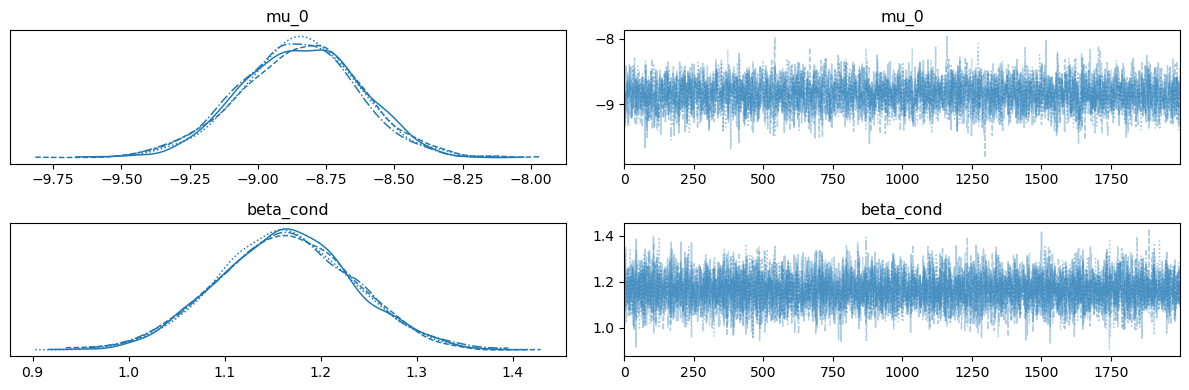

In [84]:
# Trace plots for MCMC diagnostics
az.plot_trace(trace, var_names=["mu_0", "beta_cond"])
plt.tight_layout()
plt.show()

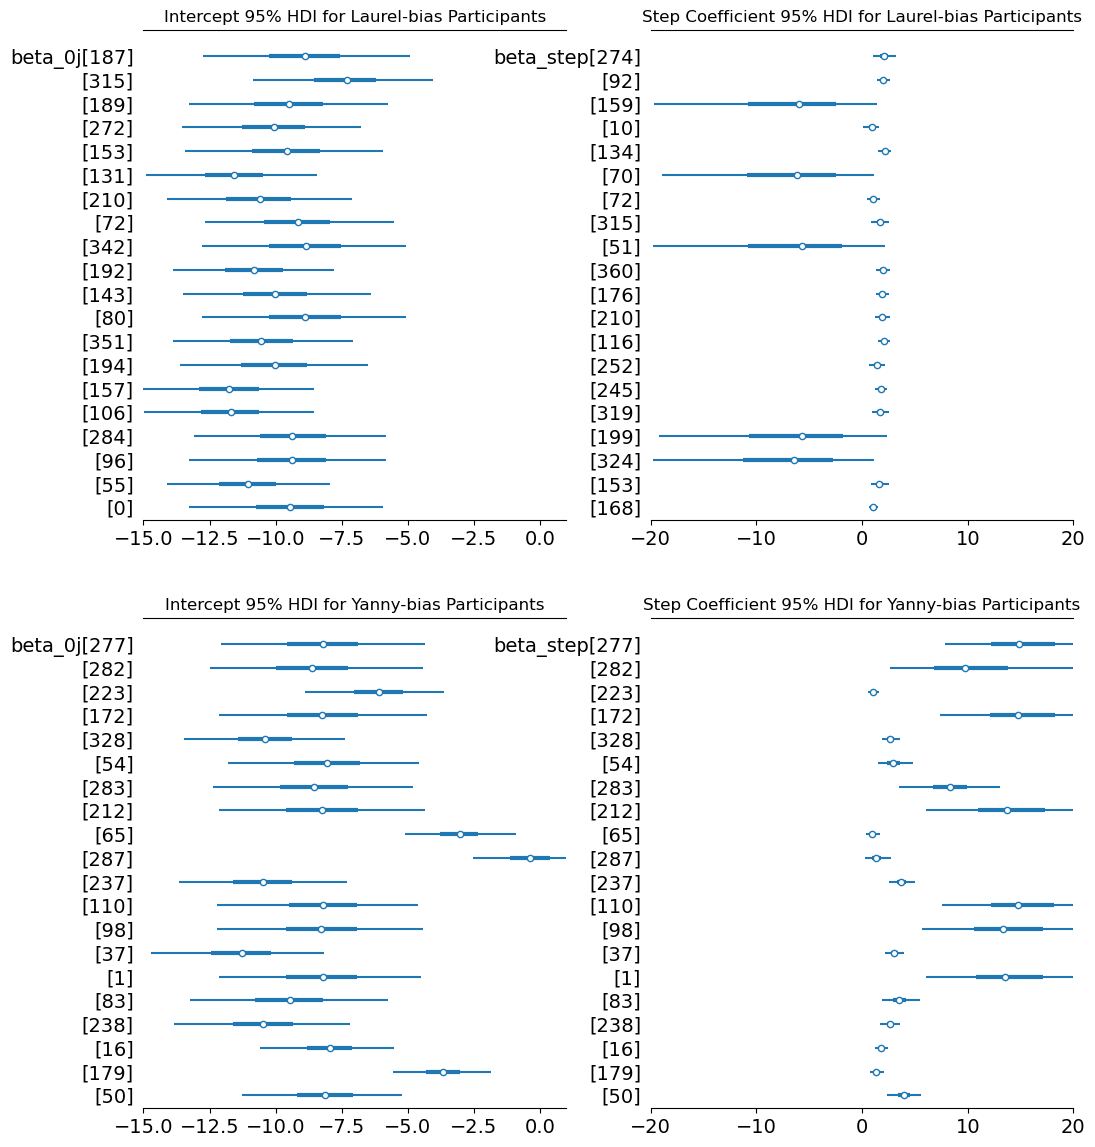

In [112]:
random.seed(1204)

fig, axs = plt.subplots(2,2, figsize=(12, 14))
axs = axs.flatten()

laurel_bias_participants = data[data['bias'] == 'Laurel']['participantID_mapped'].unique()
laurel_idx = random.sample(list(laurel_bias_participants), 20)
az.plot_forest(trace, var_names=['beta_0j'], combined=True, hdi_prob=0.95,
                  coords={'beta_0j_dim_0': laurel_idx}, ax=axs[0])
axs[0].set_xlim([-15, 1])
axs[0].set_title("Intercept 95% HDI for Laurel-bias Participants")

laurel_idx = random.sample(list(laurel_bias_participants), 20)
az.plot_forest(trace, var_names=['beta_step'], combined=True, hdi_prob=0.95,
                  coords={'beta_step_dim_0': laurel_idx}, ax=axs[1])
axs[1].set_xlim([-20, 20])
axs[1].set_title("Step Coefficient 95% HDI for Laurel-bias Participants")

random.seed(1204)

yanny_bias_participants = data[data['bias'] == 'Yanny']['participantID_mapped'].unique()
yanny_idx = random.sample(list(yanny_bias_participants), 20)
az.plot_forest(trace, var_names=['beta_0j'], combined=True, hdi_prob=0.95,
                  coords={'beta_0j_dim_0': yanny_idx}, ax=axs[2])
axs[2].set_xlim([-15, 1])
axs[2].set_title("Intercept 95% HDI for Yanny-bias Participants")

az.plot_forest(trace, var_names=['beta_step'], combined=True, hdi_prob=0.95,
                  coords={'beta_step_dim_0': yanny_idx}, ax=axs[3])
axs[3].set_xlim([-20, 20])
axs[3].set_title("Step Coefficient 95% HDI for Yanny-bias Participants");